In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [4]:
df_final = pd.read_csv('/content/02-traffic-weather.csv')

In [5]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22406 entries, 0 to 22405
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          22406 non-null  object 
 1   meridiem      22406 non-null  object 
 2   roadway name  22406 non-null  object 
 3   volume        22406 non-null  float64
 4   precip type   22406 non-null  object 
 5   temperature   22406 non-null  float64
 6   humidity      22406 non-null  float64
 7   wind speed    22406 non-null  float64
dtypes: float64(4), object(4)
memory usage: 1.4+ MB


In [4]:
df_final.head()

,date,meridiem,roadway name,volume,precip type,temperature,humidity,wind speed
0,2012-01-08,AM,3 AVE,105.645833,rain,1.495833,0.9125,9.975292
1,2012-01-08,PM,3 AVE,204.750000,rain,2.766204,0.9300,7.997675
2,2012-01-08,AM,FULTON AVENUE,176.250000,rain,1.495833,0.9125,9.975292
3,2012-01-08,PM,FULTON AVENUE,244.458333,rain,2.766204,0.9300,7.997675
4,2012-01-08,AM,VAN BRUNT ST,45.166667,rain,1.495833,0.9125,9.975292


## Feature Engineering

In [6]:
def classify_traffic(volume):
    if volume <= 1000:
        return 'Low'
    elif volume <= 2500:
        return 'Medium'
    else:
        return 'High'

# Apply the function to the 'volume' column to create a new 'traffic_type' column
df_final['traffic_type'] = df_final['volume'].apply(classify_traffic)

In [7]:
df_final.head()

,date,meridiem,roadway name,volume,precip type,temperature,humidity,wind speed,traffic_type
0,2012-01-08,AM,3 AVE,105.645833,rain,1.495833,0.9125,9.975292,Low
1,2012-01-08,PM,3 AVE,204.750000,rain,2.766204,0.9300,7.997675,Low
2,2012-01-08,AM,FULTON AVENUE,176.250000,rain,1.495833,0.9125,9.975292,Low
3,2012-01-08,PM,FULTON AVENUE,244.458333,rain,2.766204,0.9300,7.997675,Low
4,2012-01-08,AM,VAN BRUNT ST,45.166667,rain,1.495833,0.9125,9.975292,Low


In [8]:
print(df_final['precip type'].nunique())
print(df_final['precip type'].unique())
print(df_final['precip type'].value_counts())

5
['rain' 'snow' 'cloudy' 'fog' 'clear']
precip type
rain      19160
snow       2527
cloudy      470
clear       182
fog          67
Name: count, dtype: int64


In [9]:
df_final.traffic_type.value_counts()

traffic_type
Low       20378
Medium     1603
High        425
Name: count, dtype: int64

In [10]:


# Assuming df_final is your DataFrame with features and 'traffic_type' as the target
X = df_final.drop(['date','traffic_type','roadway name'], axis=1)
y = df_final['traffic_type']

label_encoder_y = LabelEncoder()
y = label_encoder_y.fit_transform(y)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [25]:
label_encoder_y.classes_

array(['High', 'Low', 'Medium'], dtype=object)

In [11]:
label_encoder_meridiem = LabelEncoder()
X_train['meridiem'] = label_encoder_meridiem.fit_transform(X_train['meridiem'])
X_test['meridiem'] = label_encoder_meridiem.transform(X_test['meridiem'])

In [16]:
train_encode= OneHotEncoder(handle_unknown='ignore')

precip_encoded = pd.DataFrame(train_encode.fit_transform(X_train[['precip type']]).toarray(), columns=train_encode.get_feature_names_out())
X_train=X_train.reset_index()
X_train = pd.concat([X_train.drop(['precip type'], axis=1), precip_encoded], axis=1)

In [18]:
precip_encoded = pd.DataFrame(train_encode.fit_transform(X_test[['precip type']]).toarray(), columns=train_encode.get_feature_names_out())
X_test=X_test.reset_index()
X_test = pd.concat([X_test.drop(['precip type'], axis=1), precip_encoded], axis=1)

In [19]:
# Scaling 'temperature'
scaler = StandardScaler()
X_train[['temperature', 'humidity', 'wind speed', 'volume']] = scaler.fit_transform(X_train[['temperature', 'humidity', 'wind speed', 'volume']])
X_test[['temperature', 'humidity', 'wind speed', 'volume']] = scaler.transform(X_test[['temperature', 'humidity', 'wind speed', 'volume']])

## Classification Modelling

In [23]:
# Compute class weights to handle imbalanced classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

# Initialize and train the RandomForestClassifier
rf_model = RandomForestClassifier(class_weight=class_weights_dict, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
report_rf = classification_report(y_test, y_pred, target_names=label_encoder_y.classes_)
matrix_rf = confusion_matrix(y_test, y_pred)

print(report_rf)
print(matrix_rf)

              precision    recall  f1-score   support

        High       1.00      1.00      1.00        41
         Low       1.00      1.00      1.00      2053
      Medium       1.00      1.00      1.00       147

    accuracy                           1.00      2241
   macro avg       1.00      1.00      1.00      2241
weighted avg       1.00      1.00      1.00      2241

[[  41    0    0]
 [   0 2053    0]
 [   0    0  147]]


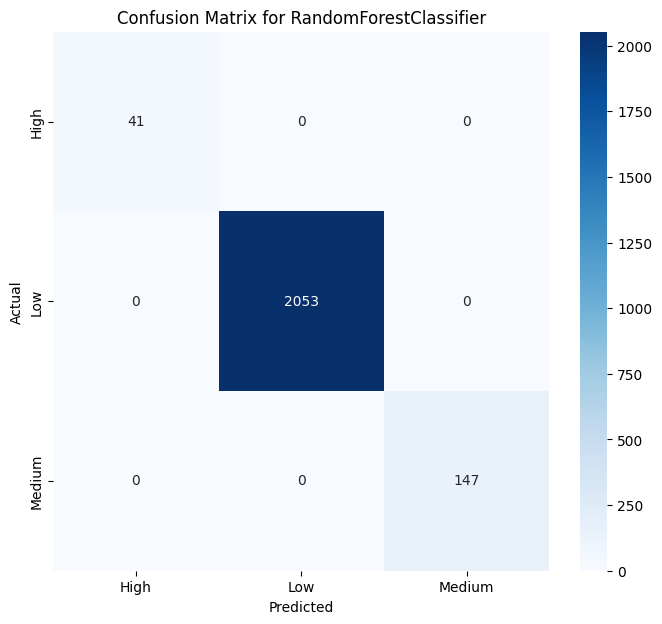

In [57]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_y.classes_, yticklabels=label_encoder_y.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for RandomForestClassifier')
plt.show()